In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

from utils.funs import scores

from transformers import AlbertModel

/opt/homebrew/Caskroom/miniconda/base/envs/attention-geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def getscoresALBERT(d,l,h,dh,model):
    """
    Let Q and K be
    Q = X @ W_q ; K = X @ W_k

    it follows that the dot product between queries and keys is 
    Q @ K^T = X @ (W_q @ W_k^T) @ X^T = X @ M @ X^T 

    where M is a square matrix \in R^{d,d}, that can be decomposed into its
    symmetric and skew-symmetric part S and N, respectively,
    M = 1/2 * (M + M^T) + 1/2 * (M - M^T) = S + N

    important: nn.Linear.weight returns the learnable weights of the module as
    (out_features,in_features), then we can access the matrix W_q or 
    W_k as nn.Linear.weight^T

    Args:
        - d (int) : embeddding dimension.
        - l (int) : total number of layers
        - h (int) : number of heads.
        - dh (int) : embedding dimension per head.
        - model () : full model.

    Returns:
        - SList (numpy ndarray) : List of Symmetric (S) scores.
        - NList (numpy ndarray) : List of Skew-symmetric (N) scores.
    """

    SList = np.zeros((l,h))
    NList = np.zeros((l,h))
    
    # retrieve all BertLayer instances (the encoder in each layer)
    layers = model.encoder.albert_layer_groups

    for i, layer in enumerate(layers):

        # access self-attention module within layer
        self_attention = layer.albert_layers[0].attention

        # access W_q and W_k: transpose the weight matrix and split into heads
        Wq = self_attention.query._parameters["weight"].T.view(d,h,dh).detach().numpy()
        Wk = self_attention.key._parameters["weight"].T.view(d,h,dh).detach().numpy()

        for j in range(h):
            
            # calculate the association matrix M
            M = Wq[:,j,:] @ Wk[:,j,:].T
            # compute symmetry and skew-symmetry scores
            S, N = scores(M)
            SList[i,j], NList[i,j] = S, N

    return  SList, NList

In [3]:
"""
- KEY (str): model name
- VALUES (list): [layers (int), 
                  embedding dim (int), 
                  heads (int), 
                  head dim (int), 
                  S scores, 
                  N scores]
"""

if os.path.isfile('../_data/fig_scores/ALBERTmodels.pkl'):
    with open('../_data/fig_scores/ALBERTmodels.pkl', 'rb') as file:
        models = pickle.load(file)
else: models = {}

In [4]:
dh = 64

'ALBERT base model (l = 12, d = 768, h = 12 ; tot num parameters 11M)'
l = 1
d = 768
h = d // dh
model = AlbertModel.from_pretrained("albert-base-v2")
S, N = getscoresALBERT(d,l,h,dh,model)
models['ALBERTbase'] = [l,d,h,dh,S,N]

'ALBERT large model (l = 24, d = 1024, h = 16 ; tot num parameters 17M)'
l = 1
d = 1024
h = d // dh
model = AlbertModel.from_pretrained("albert-large-v2")
S, N = getscoresALBERT(d,l,h,dh,model)
models['ALBERTlarge'] = [l,d,h,dh,S,N]

'ALBERT xlarge model (l = 24, d = 2048, h = 16 ; tot num parameters 58M)'
dh = 64
l = 1
d = 2048
h = d // dh
model = AlbertModel.from_pretrained("albert-xlarge-v2")
S, N = getscoresALBERT(d,l,h,dh,model)
models['ALBERTxlarge'] = [l,d,h,dh,S,N]

'ALBERT xxlarge model (l = 12, d = 4096, h = 64 ; tot num parameters 223M)'
dh = 64
l = 1
d = 4096
h = d // dh
model = AlbertModel.from_pretrained("albert-xxlarge-v2")
S, N = getscoresALBERT(d,l,h,dh,model)
models['ALBERTxxlarge'] = [l,d,h,dh,S,N]

'save'
with open('../_data/fig_scores/ALBERTmodels.pkl', 'wb') as file:
    pickle.dump(models, file)

(0.0, 1.0)

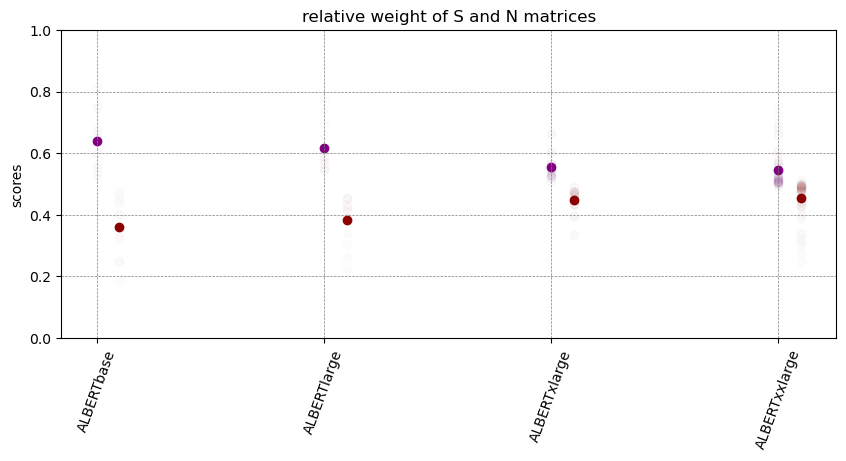

In [5]:
import matplotlib.pyplot as plt

with open('../_data/fig_scores/ALBERTmodels.pkl', 'rb') as file:
    models = pickle.load(file)

SList = [models[key][-2].flatten() for key in list(models.keys())]
NList = [models[key][-1].flatten() for key in list(models.keys())]
names = list(models.keys())

plt.figure(figsize=(10,4))

for i, model in enumerate(SList):
    
    plt.scatter(i*np.ones(SList[i].size),(SList[i].flatten()**2),color='purple',alpha=.01)
    plt.scatter(i,(SList[i].flatten()**2).mean(),color='purple')

    plt.scatter((i+.1)*np.ones(NList[i].size),(NList[i].flatten()**2),color='darkred',alpha=.01)
    plt.scatter(i+.1,(NList[i].flatten()**2).mean(),color='darkred')
    
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.title('relative weight of S and N matrices')
plt.ylabel('scores')
plt.xticks(np.arange(len(names)),names)
plt.xticks(rotation=70)
plt.ylim(0,1)